# Churn Rate Prediction 

## Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
## Importing Data
data = pd.read_csv('Bookings.csv')

## Show the first 5 rows of Data
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
## Copy the dataset ( So that the original data remain unchanged)
df = data.copy()

In [4]:
## Find the missing value, show the total null values for each column and sort it in descending order
df.isnull().sum().sort_values(ascending=False)[:10]

company                   112593
agent                      16340
country                      488
children                       4
reserved_room_type             0
assigned_room_type             0
booking_changes                0
deposit_type                   0
hotel                          0
previous_cancellations         0
dtype: int64

In [5]:
# We have 4 features with missing values.
# In the agent and the company column, we have id_number for each agent or company, 
# so for all the missing values, we will just replace it with 0.

In [6]:
## If no id of agent or company is null, just replace it with 0
df[['agent','company']] = df[['agent','company']].fillna(0.0)

In [7]:
# Children column contains the count of children, so we will replace all the missing values with the rounded mean value.
# Country column contains country codes representing different countries. 
# Since it is categorical it is replace with the mode value or value that appears more than any other value. 

## For the missing values in the country column, replace it with mode 
df['country'].fillna(data.country.mode().to_string(), inplace=True)


## for missing children value, replace it with rounded mean value
df['children'].fillna(round(data.children.mean()), inplace=True)

In [8]:
# There are many rows that have zero guests including adults, children and babies. 
df[(df.adults+df.babies+df.children)==0].shape

(180, 32)

In [9]:
## Drop Rows where there is no adult, baby and child (180 rows)
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)

# Converting Datatype

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119210 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119210 non-null  object 
 1   is_canceled                     119210 non-null  int64  
 2   lead_time                       119210 non-null  int64  
 3   arrival_date_year               119210 non-null  int64  
 4   arrival_date_month              119210 non-null  object 
 5   arrival_date_week_number        119210 non-null  int64  
 6   arrival_date_day_of_month       119210 non-null  int64  
 7   stays_in_weekend_nights         119210 non-null  int64  
 8   stays_in_week_nights            119210 non-null  int64  
 9   adults                          119210 non-null  int64  
 10  children                        119210 non-null  float64
 11  babies                          119210 non-null  int64  
 12  meal            

In [11]:
# We can see different data types for different columns.
# There are some columns like children, company, and agent, that are float type but their values are only in integers.
# So we will convert them to the integer type.

In [12]:
## convert datatype of these columns from float to integer
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')


# Exploratory Data Analysis

In [13]:
def get_count(series, limit=None):
    
    '''
    INPUT:
        series: Pandas Series (Single Column from DataFrame)
        limit:  If value given, limit the output value to first limit samples.
    OUTPUT:
        x = Unique values
        y = Count of unique values
    '''
    
    if limit != None:
        series = series.value_counts()[:limit]
    else:
        series = series.value_counts()
    
    x = series.index
    y = series/series.sum()*100
    
    return x.values,y.values

# This function takes a series or data frame column and returns the two arrays
# x is our unique values
# y is the percentage value of each unique value


In [14]:
x,y = get_count(df['is_canceled'])
x,y

(array([0, 1], dtype=int64), array([62.92341247, 37.07658753]))

In [15]:
# is_canceled have two unique values: 1 if booking got canceled, else 0.

In [16]:
import matplotlib.ticker as mtick

def plot(x, y, x_label=None,y_label=None, title=None, figsize=(7,5), type='bar'):
    
    '''
    INPUT:
        x:        Array containing values for x-axis
        y:        Array containing values for y-axis
        x_lable:  String value for x-axis label
        y_lable:  String value for y-axis label
        title:    String value for plot title
        figsize:  tuple value, for figure size
        type:     type of plot (default is bar plot)
        
    OUTPUT:
        Display the plot
    '''
    
    sns.set_style('darkgrid')
    
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    if x_label != None:
        ax.set_xlabel(x_label)
    
    if y_label != None:
        ax.set_ylabel(y_label)
        
    if title != None:
        ax.set_title(title)
    
    if type == 'bar':
        sns.barplot(x,y, ax = ax)
    elif type == 'line':
        sns.lineplot(x,y, ax = ax, sort=False)
        
    
    plt.show()
    
#This function takes two arrays, x, and y and displays the required diagram. 
# The default plot type is a bar plot, but it can also plot the line plot.
# Optional arguments can be given to display title and labels.    

C:\Users\Subir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


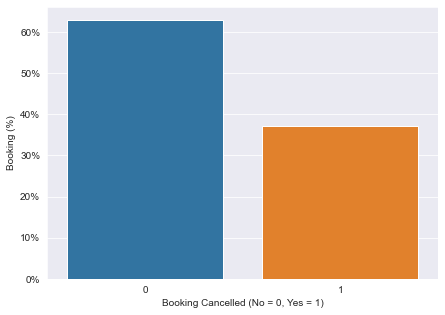

In [17]:
plot(x,y, x_label='Booking Cancelled (No = 0, Yes = 1)', y_label='Booking (%)')
plt.show()    

In [18]:
# Findings:
# Bookings got canceled 37% of the time. 
# Did not cancel the booking almost 63% of the time.

In [19]:
# For further analysis, We will select only those bookings which did not get canceled

df_not_canceled = df[df['is_canceled'] == 0]

C:\Users\Subir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


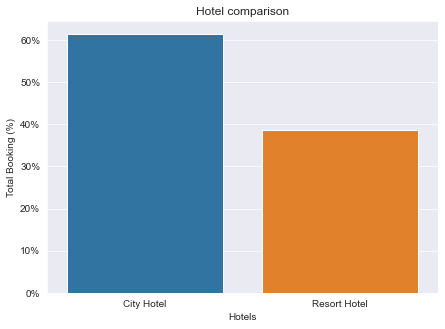

In [20]:
# 2. What is the booking ratio between Resort Hotel and City Hotel?

x,y = get_count(df_not_canceled['hotel'])
plot(x,y, x_label='Hotels', y_label='Total Booking (%)', title='Hotel comparison')

In [21]:
# More than 60% of the population booked the City hotel

C:\Users\Subir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


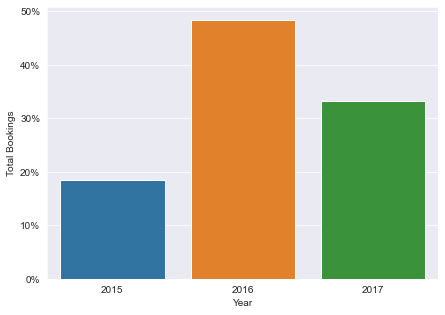

In [22]:
# 3. What is the percentage of booking for each year?

x,y = get_count(df_not_canceled['arrival_date_year'])
plot(x,y,x_label="Year", y_label= "Total Bookings")

In [23]:
# More than double bookings were made in 2016, compared to the previous year.
# But the bookings decreased by almost 15% the next year.

C:\Users\Subir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


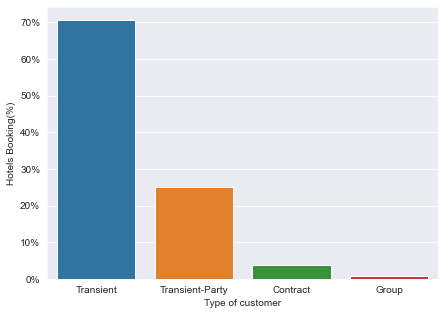

In [24]:
# 
x,y= get_count(df_not_canceled['customer_type'])
plot(x,y,x_label='Type of customer' ,y_label='Hotels Booking(%)')

In [25]:
# Getting catgorical features in data
df_cat = [col for col in df if df[col].dtype == "O"]
df_cat

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

C:\Users\Subir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


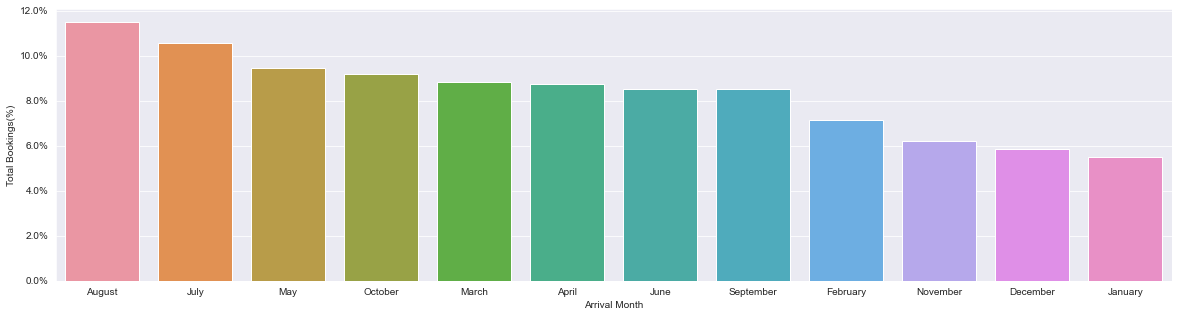

In [26]:
x,y = get_count(df_not_canceled['arrival_date_month'])
plot(x,y, x_label='Arrival Month', y_label='Total Bookings(%)', figsize=(20,5))

C:\Users\Subir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


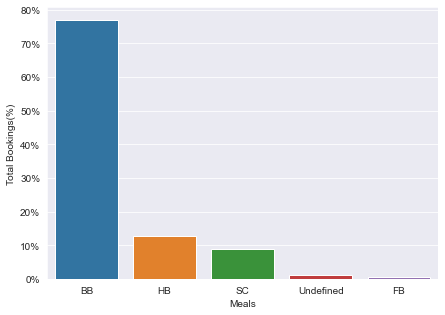

In [27]:
x,y = get_count(df_not_canceled['meal'])
plot(x,y, x_label='Meals', y_label='Total Bookings(%)')

C:\Users\Subir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


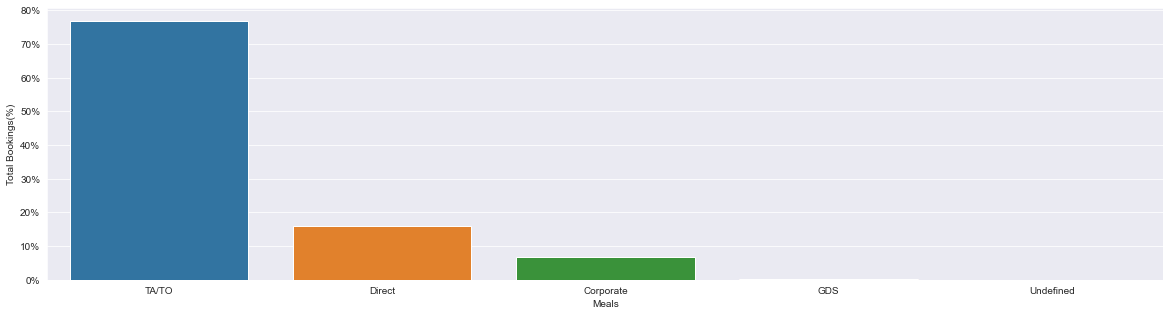

In [28]:
x,y = get_count(df_not_canceled['distribution_channel'])
plot(x,y, x_label='Meals', y_label='Total Bookings(%)', figsize=(20,5))

C:\Users\Subir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


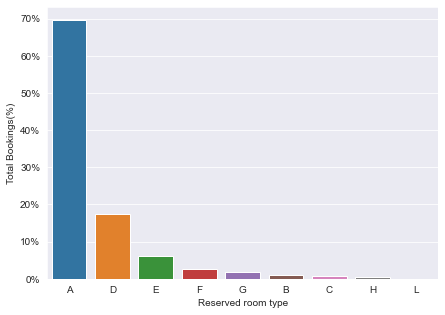

In [29]:
x,y = get_count(df_not_canceled['reserved_room_type'])
plot(x,y, x_label='Reserved room type', y_label='Total Bookings(%)')

C:\Users\Subir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


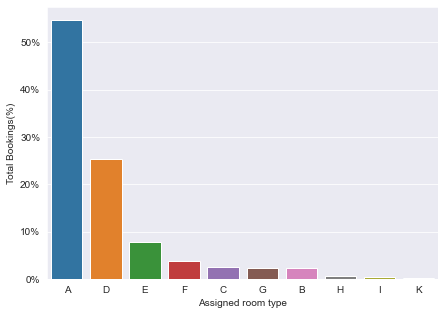

In [30]:
x,y = get_count(df_not_canceled['assigned_room_type'])
plot(x,y, x_label='Assigned room type', y_label='Total Bookings(%)')

C:\Users\Subir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


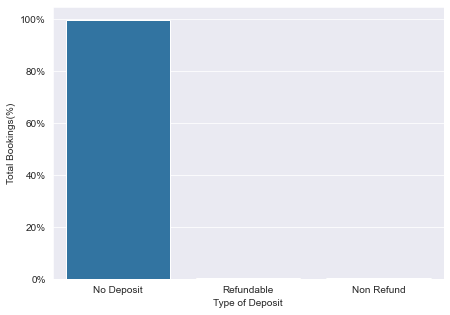

In [31]:
x,y = get_count(df_not_canceled['deposit_type'])
plot(x,y, x_label='Type of Deposit', y_label='Total Bookings(%)')

C:\Users\Subir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


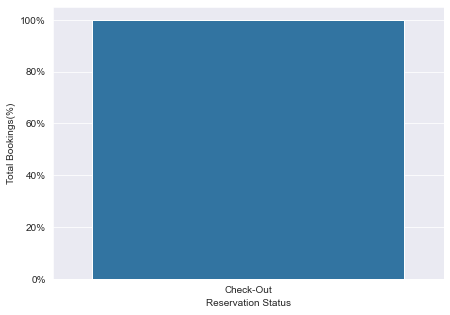

In [32]:
x,y = get_count(df_not_canceled['reservation_status'])
plot(x,y, x_label='Reservation Status', y_label='Total Bookings(%)')

In [33]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(df, title="Pandas Profiling Report")
#profile

In [34]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,0,0,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,0,0,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,0,0,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304,0,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240,0,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394,0,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9,0,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9,0,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89,0,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [35]:
## Copy the dataframe
df_subset = df.copy()

In [36]:
## Make the new column which contain 1 if guest received the same room which was reserved otherwise 0
df_subset['Room'] = 0
df_subset.loc[ df_subset['reserved_room_type'] == df_subset['assigned_room_type'] , 'Room'] = 1


## Make the new column which contain 1 if the guest has cancelled more booking in the past
## than the number of booking he did not cancel, otherwise 0

df_subset['net_cancelled'] = 0
df_subset.loc[ df_subset['previous_cancellations'] > df_subset['previous_bookings_not_canceled'] , 'net_cancelled'] = 1

In [37]:
df_subset

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Room,net_cancelled
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,0,Transient,75.00,0,0,Check-Out,2015-07-02,0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,0,Transient,98.00,0,1,Check-Out,2015-07-03,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,0,Transient,96.14,0,0,Check-Out,2017-09-06,1,0
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,0,Transient,225.43,0,2,Check-Out,2017-09-07,1,0
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,0,Transient,157.71,0,4,Check-Out,2017-09-07,1,0
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,0,Transient,104.40,0,0,Check-Out,2017-09-07,1,0


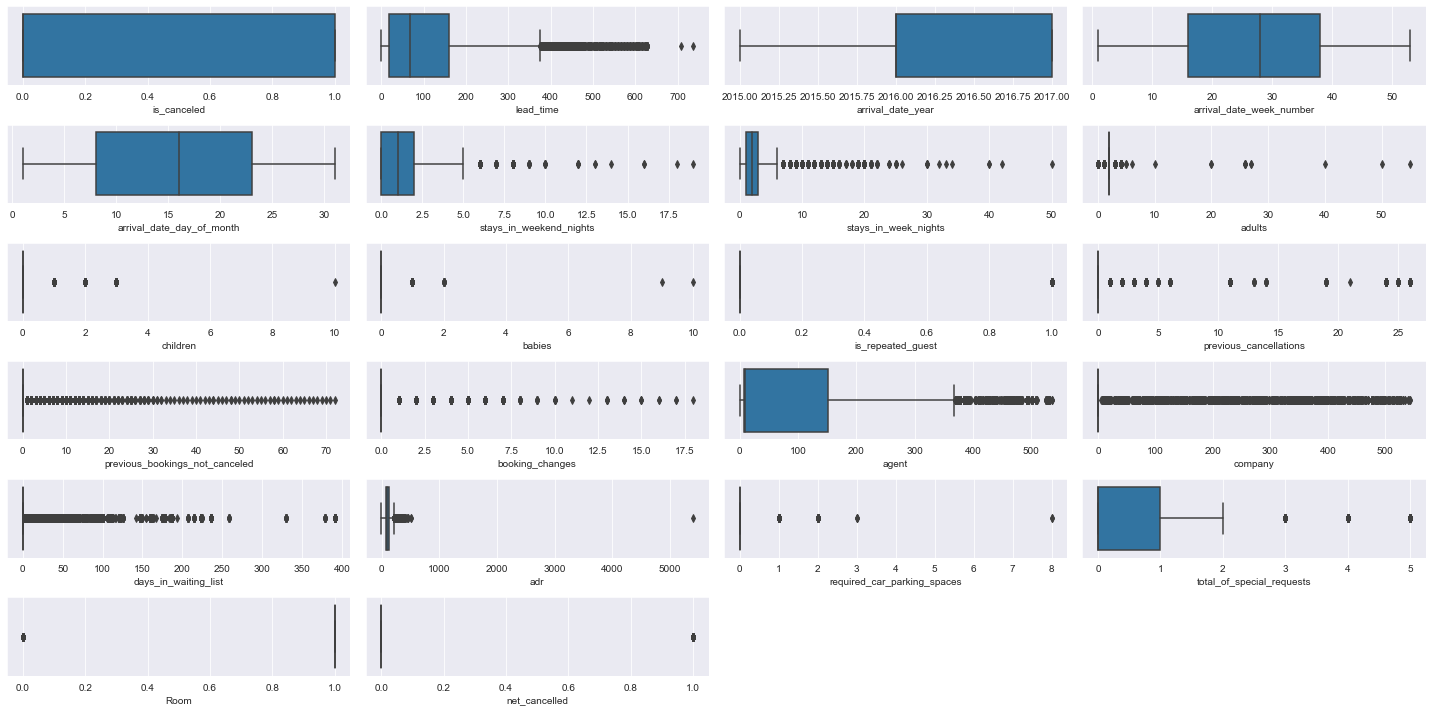

In [38]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize = (20, 10))
x = 1 

for column in df_subset.describe().columns:
    plt.subplot(6,4,x)
    sns.boxplot(df_subset[column])
    x+=1
    
plt.tight_layout()

<AxesSubplot:xlabel='lead_time', ylabel='Density'>

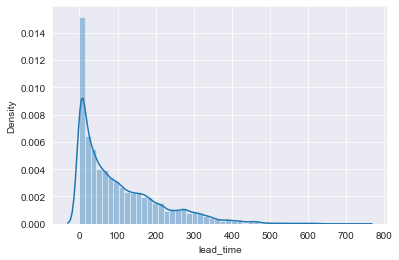

In [39]:
sns.distplot(df_subset['lead_time'])

In [40]:
# Lets compute the Interquantile range to calculate the boundaries
IQR=df_subset.lead_time.quantile(0.75)-df_subset.lead_time.quantile(0.25)
IQR

143.0

In [41]:
# Outliers which 1.5 standard deviation away
lower_limit=df_subset['lead_time'].quantile(0.25)-(IQR*1.5)
upper_limit=df_subset['lead_time'].quantile(0.75)+(IQR*1.5)
print(lower_limit), print(upper_limit)

-196.5
375.5


(None, None)

In [42]:
print(lower_limit), print(upper_limit)

-196.5
375.5


(None, None)

In [43]:
df_subset[df_subset['lead_time']>upper_limit]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Room,net_cancelled
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,0
225,Resort Hotel,0,394,2015,July,28,8,2,5,2,...,0,0,Contract,89.68,0,0,Check-Out,2015-07-15,1,0
890,Resort Hotel,0,460,2015,August,32,3,2,5,1,...,0,0,Contract,77.54,0,0,Check-Out,2015-08-10,1,0
1516,Resort Hotel,0,381,2015,September,36,1,4,10,2,...,0,0,Contract,82.88,0,0,Check-Out,2015-09-15,1,0
1672,Resort Hotel,0,382,2015,September,37,8,4,10,2,...,0,0,Contract,76.50,0,0,Check-Out,2015-09-22,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119102,City Hotel,0,518,2017,August,34,26,2,1,1,...,0,0,Transient-Party,0.00,0,0,Check-Out,2017-08-29,1,0
119107,City Hotel,0,518,2017,August,34,26,2,1,2,...,0,0,Transient-Party,112.67,0,1,Check-Out,2017-08-29,1,0
119109,City Hotel,0,518,2017,August,34,26,2,1,2,...,0,0,Transient-Party,112.67,0,1,Check-Out,2017-08-29,1,0
119111,City Hotel,0,518,2017,August,34,26,2,1,2,...,0,0,Transient-Party,112.67,0,1,Check-Out,2017-08-29,1,0


In [44]:
df_subset[df_subset['lead_time']>upper_limit].shape

(2981, 34)

In [45]:
df_subset['lead_time']=np.where(df_subset['lead_time']>upper_limit,upper_limit,df_subset['lead_time'])

<AxesSubplot:xlabel='lead_time'>

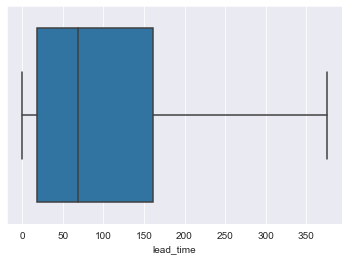

In [46]:
sns.boxplot(df_subset['lead_time'])

<AxesSubplot:xlabel='stays_in_weekend_nights', ylabel='Density'>

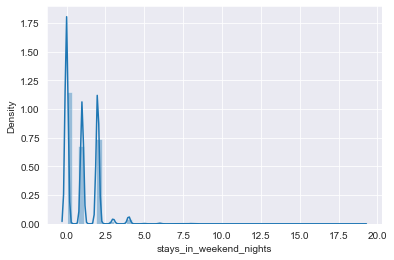

In [47]:
sns.distplot(df_subset['stays_in_weekend_nights'])


In [48]:
# Lets compute the Interquantile range to calculate the boundaries
IQR=df_subset.stays_in_weekend_nights.quantile(0.75)-df_subset.stays_in_weekend_nights.quantile(0.25)
IQR

# Outliers which 1.5 standard deviation away
lower_limit=df_subset['stays_in_weekend_nights'].quantile(0.25)-(IQR*1.5)
upper_limit=df_subset['stays_in_weekend_nights'].quantile(0.75)+(IQR*1.5)
print(lower_limit), print(upper_limit)

df_subset[df_subset['stays_in_weekend_nights']>upper_limit].shape



-3.0
5.0


(258, 34)

In [49]:
df_subset['stays_in_weekend_nights']=np.where(df_subset['stays_in_weekend_nights']>upper_limit,upper_limit,df_subset['stays_in_weekend_nights'])

<AxesSubplot:xlabel='stays_in_weekend_nights', ylabel='Density'>

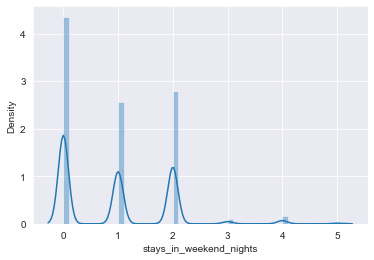

In [50]:
sns.distplot(df_subset['stays_in_weekend_nights'])

<AxesSubplot:xlabel='stays_in_weekend_nights'>

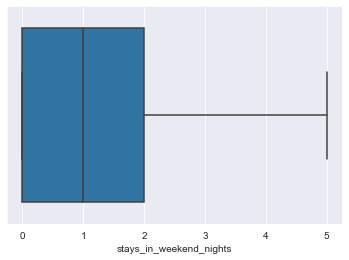

In [51]:
sns.boxplot(df_subset['stays_in_weekend_nights'])

In [52]:
IQR=df_subset.stays_in_week_nights.quantile(0.75)-df_subset.stays_in_week_nights.quantile(0.25)
IQR

# Outliers which 1.5 standard deviation away
lower_limit=df_subset['stays_in_week_nights'].quantile(0.25)-(IQR*1.5)
upper_limit=df_subset['stays_in_week_nights'].quantile(0.75)+(IQR*1.5)
print(lower_limit), print(upper_limit)

df_subset[df_subset['stays_in_weekend_nights']>upper_limit].shape



-2.0
6.0


(0, 34)

In [53]:
df_subset['stays_in_week_nights']=np.where(df_subset['stays_in_week_nights']>upper_limit,upper_limit,df_subset['stays_in_week_nights'])

<AxesSubplot:xlabel='stays_in_week_nights', ylabel='Density'>

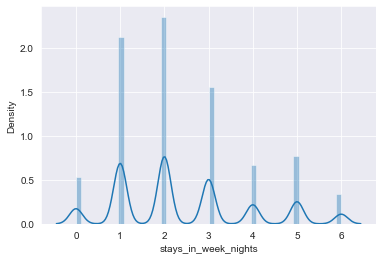

In [54]:
sns.distplot(df_subset['stays_in_week_nights'])

<AxesSubplot:xlabel='stays_in_week_nights'>

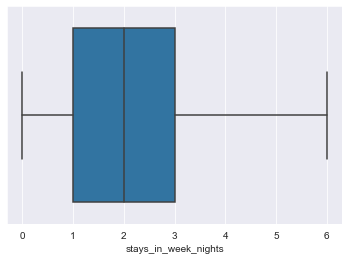

In [55]:
sns.boxplot(df_subset['stays_in_week_nights'])

<AxesSubplot:xlabel='adults', ylabel='Density'>

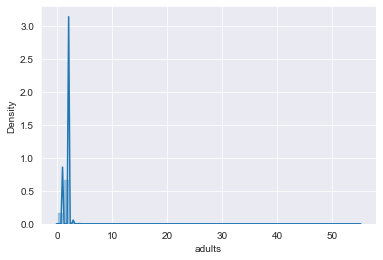

In [56]:
sns.distplot(df_subset['adults'])

In [57]:
# "adults"
IQR=df_subset.adults.quantile(0.75)-df_subset.adults.quantile(0.25)
IQR

# Outliers which 1.5 standard deviation away
upper_limit=df_subset['adults'].quantile(0.75)+(IQR*1.5)
lower_limit=df_subset['adults'].quantile(0.25)-(IQR*1.5)
upper_limit=df_subset['adults'].quantile(0.75)+(IQR*1.5)
print(lower_limit), print(upper_limit)

df_subset[df_subset['adults']>upper_limit].shape



2.0
2.0


(6280, 34)

In [58]:
df_subset['adults']=np.where(df_subset['adults']>upper_limit,upper_limit,df_subset['adults'])
df_subset['adults']=np.where(df_subset['adults']<lower_limit,lower_limit,df_subset['adults'])

<AxesSubplot:xlabel='adults', ylabel='Density'>

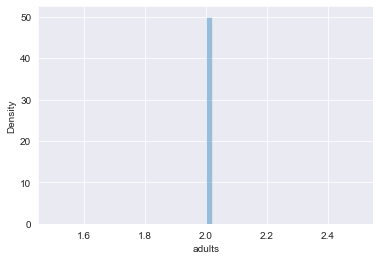

In [59]:
sns.distplot(df_subset['adults'])

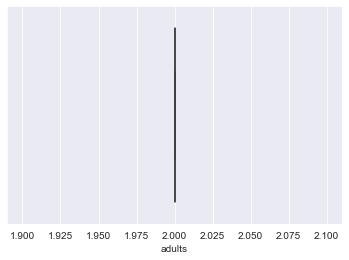

In [60]:
s1 = sns.boxplot(df_subset['adults'])

<AxesSubplot:xlabel='children', ylabel='Density'>

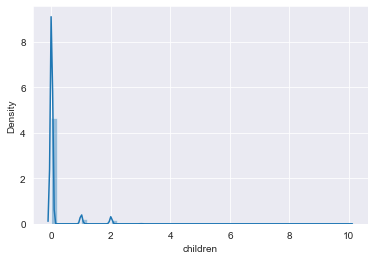

In [61]:
sns.distplot(df_subset['children'])

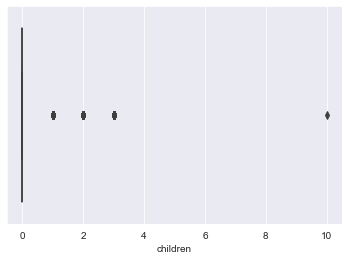

In [62]:
s3 = sns.boxplot(df_subset['children'])

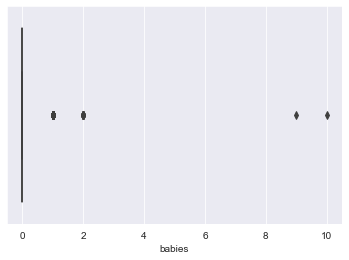

In [63]:

s3 = sns.boxplot(df_subset['babies'])

In [64]:
# "children"
IQR=df_subset.children.quantile(0.75)-df_subset.children.quantile(0.25)
IQR

# Outliers which 1.5 standard deviation away
upper_limit=df_subset['children'].quantile(0.75)+(IQR*1.5)
lower_limit=df_subset['children'].quantile(0.25)-(IQR*1.5)
upper_limit=df_subset['children'].quantile(0.75)+(IQR*1.5)
print(lower_limit), print(upper_limit)

df_subset[df_subset['adults']>upper_limit].shape

0.0
0.0


(119210, 34)

In [65]:
df_subset['children']=np.where(df_subset['children']>upper_limit,upper_limit,df_subset['children'])

<AxesSubplot:xlabel='children', ylabel='Density'>

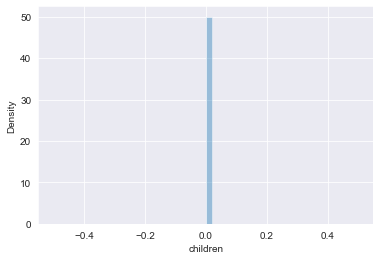

In [66]:
sns.distplot(df_subset['children'])

In [67]:
# "babies"
IQR=df_subset.children.quantile(0.75)-df_subset.children.quantile(0.25)
IQR

# Outliers which 1.5 standard deviation away
upper_limit=df_subset['babies'].quantile(0.75)+(IQR*1.5)
lower_limit=df_subset['babies'].quantile(0.25)-(IQR*1.5)
upper_limit=df_subset['babies'].quantile(0.75)+(IQR*1.5)
print(lower_limit), print(upper_limit)

df_subset[df_subset['babies']>upper_limit].shape

0.0
0.0


(917, 34)

In [68]:
df_subset['babies']=np.where(df_subset['babies']>upper_limit,upper_limit,df_subset['babies'])

<AxesSubplot:xlabel='babies', ylabel='Density'>

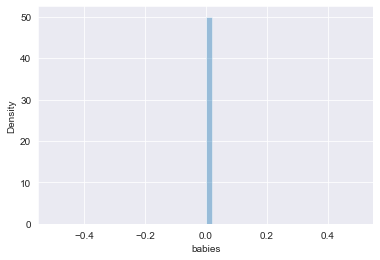

In [69]:
sns.distplot(df_subset['babies'])

<AxesSubplot:xlabel='adr', ylabel='Density'>

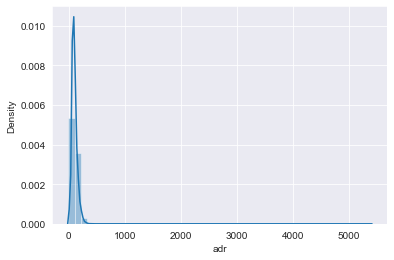

In [70]:
sns.distplot(df_subset['adr'])

In [71]:
# "adr"
IQR=df_subset.adr.quantile(0.75)-df_subset.adr.quantile(0.25)
IQR

# Outliers which 1.5 standard deviation away
upper_limit=df_subset['adr'].quantile(0.75)+(IQR*1.5)
lower_limit=df_subset['adr'].quantile(0.25)-(IQR*1.5)
upper_limit=df_subset['adr'].quantile(0.75)+(IQR*1.5)
print(lower_limit), print(upper_limit)

df_subset[df_subset['adr']>upper_limit].shape

-15.25
210.75


(3864, 34)

In [72]:
df_subset['adr']=np.where(df_subset['adr']>upper_limit,upper_limit,df_subset['adr'])

In [73]:
df_subset[df_subset['adr']>upper_limit].shape

(0, 34)

<AxesSubplot:xlabel='adr', ylabel='Density'>

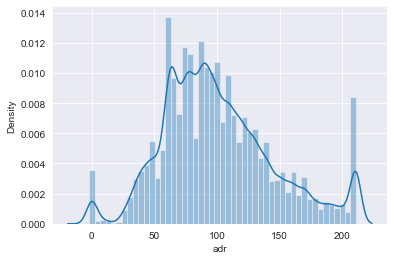

In [74]:
sns.distplot(df_subset['adr'])

<AxesSubplot:xlabel='adr'>

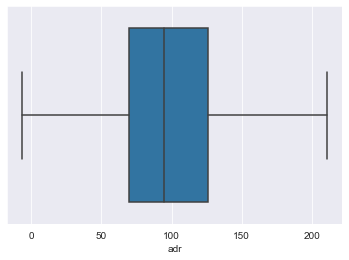

In [75]:
sns.boxplot(df_subset['adr'])

# FEATURE ENGINEERING


In [76]:
# 1. Converting Categorical variables to Numerical
# Let’s convert categorical values into numerical form.
# We will use LabelEncoder from Sklearn

In [77]:
categorical= [i for i in df_subset.columns if df_subset[i].dtypes == "O"]

In [78]:
categorical

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [79]:
#to check the length of the unique values in the categorical data 
for feature in categorical:
    print(f" {feature} : {len(df_subset[feature].unique())}")

 hotel : 2
 arrival_date_month : 12
 meal : 5
 country : 178
 market_segment : 8
 distribution_channel : 5
 reserved_room_type : 9
 assigned_room_type : 11
 deposit_type : 3
 customer_type : 4
 reservation_status : 3
 reservation_status_date : 926


In [80]:
# To check the frequencies of the unique values present in the categorical data 
for feature in categorical:
    print(df_subset[feature].value_counts())
    print("\n \n")

City Hotel      79163
Resort Hotel    40047
Name: hotel, dtype: int64

 

August       13861
July         12644
May          11780
October      11147
April        11078
June         10929
September    10500
March         9768
February      8052
November      6771
December      6759
January       5921
Name: arrival_date_month, dtype: int64

 

BB           92236
HB           14458
SC           10549
Undefined     1169
FB             798
Name: meal, dtype: int64

 

PRT    48483
GBR    12120
FRA    10401
ESP     8560
DEU     7285
       ...  
MMR        1
DJI        1
SLE        1
NCL        1
FJI        1
Name: country, Length: 178, dtype: int64

 

Online TA        56408
Offline TA/TO    24182
Groups           19791
Direct           12582
Corporate         5282
Complementary      728
Aviation           235
Undefined            2
Name: market_segment, dtype: int64

 

TA/TO        97750
Direct       14611
Corporate     6651
GDS            193
Undefined        5
Name: distribution_channe

In [81]:
df_subset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'Room',
       'net_cancelled'],
      dtype='object')

In [82]:
df_subset.drop(['previous_cancellations','previous_bookings_not_canceled','reserved_room_type','assigned_room_type','country'], axis=1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Room,net_cancelled
0,Resort Hotel,0,342.0,2015,July,27,1,0.0,0.0,2.0,...,0,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,0
1,Resort Hotel,0,375.5,2015,July,27,1,0.0,0.0,2.0,...,0,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,0
2,Resort Hotel,0,7.0,2015,July,27,1,0.0,1.0,2.0,...,0,0,Transient,75.00,0,0,Check-Out,2015-07-02,0,0
3,Resort Hotel,0,13.0,2015,July,27,1,0.0,1.0,2.0,...,0,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,0
4,Resort Hotel,0,14.0,2015,July,27,1,0.0,2.0,2.0,...,0,0,Transient,98.00,0,1,Check-Out,2015-07-03,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23.0,2017,August,35,30,2.0,5.0,2.0,...,0,0,Transient,96.14,0,0,Check-Out,2017-09-06,1,0
119386,City Hotel,0,102.0,2017,August,35,31,2.0,5.0,2.0,...,0,0,Transient,210.75,0,2,Check-Out,2017-09-07,1,0
119387,City Hotel,0,34.0,2017,August,35,31,2.0,5.0,2.0,...,0,0,Transient,157.71,0,4,Check-Out,2017-09-07,1,0
119388,City Hotel,0,109.0,2017,August,35,31,2.0,5.0,2.0,...,0,0,Transient,104.40,0,0,Check-Out,2017-09-07,1,0


In [83]:
df_subset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'Room',
       'net_cancelled'],
      dtype='object')

In [84]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder
df2 = df_subset.apply(LabelEncoder().fit_transform)
df2.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Room,net_cancelled
0,1,0,342,0,5,26,0,0,0,0,...,0,0,2,1,0,0,1,121,1,0
1,1,0,375,0,5,26,0,0,0,0,...,0,0,2,1,0,0,1,121,1,0
2,1,0,7,0,5,26,0,0,1,0,...,0,0,2,2124,0,0,1,122,0,0
3,1,0,13,0,5,26,0,0,1,0,...,0,0,2,2124,0,0,1,122,1,0
4,1,0,14,0,5,26,0,0,2,0,...,0,0,2,3523,0,1,1,123,1,0


In [85]:
## Remove the less important features
df2 = df2.drop(['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month',
                            'arrival_date_month','assigned_room_type','reserved_room_type',
                            'previous_cancellations','previous_bookings_not_canceled'],axis=1)


In [86]:
df2

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Room,net_cancelled
0,1,0,342,0,0,0,0,0,0,136,...,0,0,2,1,0,0,1,121,1,0
1,1,0,375,0,0,0,0,0,0,136,...,0,0,2,1,0,0,1,121,1,0
2,1,0,7,0,1,0,0,0,0,60,...,0,0,2,2124,0,0,1,122,0,0
3,1,0,13,0,1,0,0,0,0,60,...,0,0,2,2124,0,0,1,122,1,0
4,1,0,14,0,2,0,0,0,0,60,...,0,0,2,3523,0,1,1,123,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,0,23,2,5,0,0,0,0,16,...,0,0,2,3425,0,0,1,919,1,0
119386,0,0,102,2,5,0,0,0,0,57,...,0,0,2,7841,0,2,1,920,1,0
119387,0,0,34,2,5,0,0,0,0,44,...,0,0,2,6392,0,4,1,920,1,0
119388,0,0,109,2,5,0,0,0,0,60,...,0,0,2,3909,0,0,1,920,1,0


In [87]:
m = df2.iloc[1001:5000,:]

In [88]:
m

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Room,net_cancelled
1001,1,1,68,2,5,0,0,0,0,136,...,0,0,2,7841,0,0,0,96,1,0
1002,1,0,81,2,5,0,0,0,2,60,...,0,0,2,5258,0,0,1,167,1,0
1003,1,1,72,2,5,0,0,0,0,136,...,0,0,2,6255,0,0,0,100,1,0
1004,1,0,68,2,5,0,0,0,0,60,...,0,0,2,4029,0,0,1,167,1,0
1005,1,1,127,4,6,0,0,0,2,136,...,0,0,3,5401,0,1,0,96,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5001,1,0,187,3,6,0,0,0,2,60,...,0,0,2,4114,0,2,1,416,1,0
5002,1,1,212,2,5,0,0,0,2,136,...,0,0,2,2187,0,0,0,228,1,0
5003,1,1,212,2,5,0,0,0,2,136,...,0,0,2,2187,0,0,0,228,1,0
5004,1,1,168,0,2,0,0,0,2,136,...,0,0,2,2794,0,0,0,309,1,0


In [89]:
n = df2.iloc[1001:5000,9:]

In [90]:
n

,country,market_segment,distribution_channel,is_repeated_guest,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Room,net_cancelled
1001,136,6,3,0,0,0,174,0,0,2,7841,0,0,0,96,1,0
1002,60,5,3,0,0,0,177,0,0,2,5258,0,0,1,167,1,0
1003,136,6,3,0,0,0,174,0,0,2,6255,0,0,0,100,1,0
1004,60,5,3,0,0,0,25,0,0,2,4029,0,0,1,167,1,0
1005,136,5,3,0,0,0,28,0,0,3,5401,0,1,0,96,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5001,60,6,3,0,1,0,174,0,0,2,4114,0,2,1,416,1,0
5002,136,4,1,0,0,1,197,0,0,2,2187,0,0,0,228,1,0
5003,136,4,1,0,0,1,197,0,0,2,2187,0,0,0,228,1,0
5004,136,4,3,0,0,1,179,0,0,2,2794,0,0,0,309,1,0


In [91]:
#Spliting the data into X and Y 
X = df2.drop('is_canceled', axis = 1)
Y = df2["is_canceled"]

In [92]:
X.columns

Index(['hotel', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'babies', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'booking_changes',
       'deposit_type', 'agent', 'company', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status',
       'reservation_status_date', 'Room', 'net_cancelled'],
      dtype='object')

In [93]:
X.shape

(119210, 25)

In [94]:
Y.shape

(119210,)

In [95]:
for feature in X:
    print(f" {feature} : {list(X[feature].unique())}")

 hotel : [1, 0]
 lead_time : [342, 375, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68, 18, 37, 12, 72, 127, 78, 48, 60, 77, 99, 118, 95, 96, 69, 45, 40, 15, 36, 43, 70, 16, 107, 47, 113, 90, 50, 93, 76, 3, 1, 10, 5, 17, 51, 71, 63, 62, 101, 2, 81, 368, 364, 324, 79, 21, 109, 102, 4, 98, 92, 26, 73, 115, 86, 52, 29, 30, 33, 32, 8, 100, 44, 80, 97, 64, 39, 34, 27, 82, 94, 110, 111, 84, 66, 104, 28, 258, 112, 65, 67, 55, 88, 54, 292, 83, 105, 280, 24, 103, 366, 249, 22, 91, 11, 108, 106, 31, 87, 41, 304, 117, 59, 53, 58, 116, 42, 321, 38, 56, 49, 317, 6, 57, 19, 25, 315, 123, 46, 89, 61, 312, 299, 130, 74, 298, 119, 20, 286, 136, 129, 124, 327, 131, 140, 114, 139, 122, 137, 126, 120, 128, 135, 150, 143, 151, 132, 125, 157, 147, 138, 156, 164, 346, 159, 160, 161, 333, 149, 154, 297, 163, 314, 155, 323, 340, 356, 142, 328, 144, 336, 248, 302, 175, 344, 146, 170, 166, 338, 167, 310, 148, 165, 172, 171, 145, 121, 178, 305, 173, 152, 354, 347, 158, 185, 349, 183, 352, 177, 200, 192, 361, 207, 174, 330, 

In [96]:
X.dtypes

hotel                          int32
lead_time                      int64
stays_in_weekend_nights        int64
stays_in_week_nights           int64
adults                         int64
children                       int64
babies                         int64
meal                           int32
country                        int32
market_segment                 int32
distribution_channel           int32
is_repeated_guest              int64
booking_changes                int64
deposit_type                   int32
agent                          int64
company                        int64
days_in_waiting_list           int64
customer_type                  int32
adr                            int64
required_car_parking_spaces    int64
total_of_special_requests      int64
reservation_status             int32
reservation_status_date        int32
Room                           int64
net_cancelled                  int64
dtype: object

In [97]:
X

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Room,net_cancelled
0,1,342,0,0,0,0,0,0,136,3,...,0,0,2,1,0,0,1,121,1,0
1,1,375,0,0,0,0,0,0,136,3,...,0,0,2,1,0,0,1,121,1,0
2,1,7,0,1,0,0,0,0,60,3,...,0,0,2,2124,0,0,1,122,0,0
3,1,13,0,1,0,0,0,0,60,2,...,0,0,2,2124,0,0,1,122,1,0
4,1,14,0,2,0,0,0,0,60,6,...,0,0,2,3523,0,1,1,123,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2,5,0,0,0,0,16,5,...,0,0,2,3425,0,0,1,919,1,0
119386,0,102,2,5,0,0,0,0,57,6,...,0,0,2,7841,0,2,1,920,1,0
119387,0,34,2,5,0,0,0,0,44,6,...,0,0,2,6392,0,4,1,920,1,0
119388,0,109,2,5,0,0,0,0,60,6,...,0,0,2,3909,0,0,1,920,1,0


In [98]:
Y

0         0
1         0
2         0
3         0
4         0
         ..
119385    0
119386    0
119387    0
119388    0
119389    0
Name: is_canceled, Length: 119210, dtype: int64

In [99]:
np.savetxt('CR_Train.csv', X, delimiter=',')
np.savetxt('CR_Test.csv', Y, delimiter=',')

In [100]:
# Training using Train-Test Split

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(X,Y, test_size=0.2, random_state=20)

In [101]:
# Scalling using starndered scaler

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [102]:
X_train

array([[-0.71186115,  0.12578581,  0.08166401, ..., -0.36277416,
         0.37725756, -0.22683646],
       [-0.71186115, -0.9904934 , -0.95220475, ...,  1.04850765,
         0.37725756, -0.22683646],
       [-0.71186115,  0.00724289, -0.95220475, ..., -0.68811638,
         0.37725756, -0.22683646],
       ...,
       [ 1.40476833, -0.9904934 , -0.95220475, ...,  1.37824638,
         0.37725756, -0.22683646],
       [-0.71186115,  0.53080747,  2.14940154, ..., -0.08579362,
         0.37725756, -0.22683646],
       [-0.71186115,  0.27396447, -0.95220475, ...,  1.41781503,
         0.37725756, -0.22683646]])

In [103]:
X_test

array([[-0.71186115, -1.00037197, -0.95220475, ...,  1.00014596,
         0.37725756, -0.22683646],
       [-0.71186115, -0.56571458, -0.95220475, ..., -0.61777212,
         0.37725756, -0.22683646],
       [ 1.40476833,  0.09615008, -0.95220475, ..., -0.92552827,
         0.37725756, -0.22683646],
       ...,
       [-0.71186115,  0.0862715 ,  1.11553278, ...,  1.5409175 ,
         0.37725756, -0.22683646],
       [-0.71186115, -0.9904934 ,  0.08166401, ..., -0.90794221,
         0.37725756, -0.22683646],
       [ 1.40476833,  2.10150123,  1.11553278, ...,  0.41980578,
         0.37725756, -0.22683646]])

# Logistic Regression

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report

model_LR= LogisticRegression()
model_LR.fit(X_train, Y_train)
result = model_LR.score(X_test, Y_test)

In [105]:
result*100

99.0814528982468

In [106]:
Y_pred=model_LR.predict(X_test)

In [107]:
from sklearn.metrics import r2_score, mean_squared_error

In [108]:
print ("R2 score",r2_score(Y_test,Y_pred))
print ("RSME",np.sqrt(mean_squared_error(Y_test,Y_pred)))

R2 score 0.9606809225825111
RSME 0.09584086298407421


In [109]:
models = {
    "Logistic Regression": LogisticRegression()}
    
for name, rfmodel in models.items():
    rfmodel.fit(X_train,Y_train)
    print(name +'\n' + "Train" + ": {:.2f}%".format(rfmodel.score(X_train,Y_train) * 100))
    print("Test" + ": {:.2f}%".format(rfmodel.score(X_test,Y_test) * 100))   

Logistic Regression
Train: 98.94%
Test: 99.08%


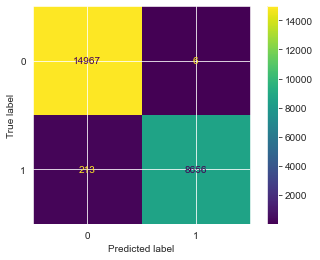

In [110]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

clf = LogisticRegression()
clf.fit(X_train, Y_train)
LogisticRegression()
plot_confusion_matrix(clf, X_test, Y_test)  
plt.show()


In [119]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14973
           1       1.00      0.98      0.99      8869

    accuracy                           0.99     23842
   macro avg       0.99      0.99      0.99     23842
weighted avg       0.99      0.99      0.99     23842



# SVM


In [111]:
models = {
    "SUPPORT VECTOR": SVC(kernel = "linear")}
    
for name, rfmodel2 in models.items():
    rfmodel2.fit(X_train,Y_train)
    print(name +'\n' + "Train" + ": {:.2f}%".format(rfmodel2.score(X_train,Y_train) * 100))
    print("Test" + ": {:.2f}%".format(rfmodel2.score(X_test,Y_test) * 100))    

SUPPORT VECTOR
Train: 98.96%
Test: 99.11%


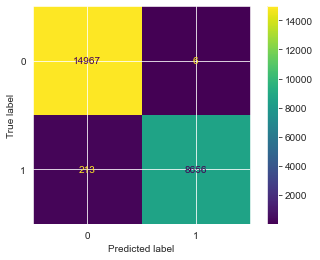

In [112]:
plot_confusion_matrix(rfmodel2, X_test, Y_test)  
plt.show()

In [116]:
Y_pred2=rfmodel2.predict(X_test)
print ("R2 score",r2_score(Y_test,Y_pred2))
print ("RSME",np.sqrt(mean_squared_error(Y_test,Y_pred2)))

R2 score 0.9617581575802506
RSME 0.09451885672883337


In [118]:
print(classification_report(Y_test, Y_pred2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14973
           1       1.00      0.98      0.99      8869

    accuracy                           0.99     23842
   macro avg       0.99      0.99      0.99     23842
weighted avg       0.99      0.99      0.99     23842



# NAIVE-BAYES

In [113]:
from sklearn.naive_bayes import GaussianNB
models = {
    "Naive Bayes": GaussianNB()}
    
for name, rfmodel in models.items():
    rfmodel.fit(X_train,Y_train)
    print(name +'\n' + "train" + ": {:.2f}%".format(rfmodel.score(X_train,Y_train) * 100))
    print("Test" + ": {:.2f}%".format(rfmodel.score(X_test,Y_test) * 100))    

Naive Bayes
train: 99.19%
Test: 99.21%


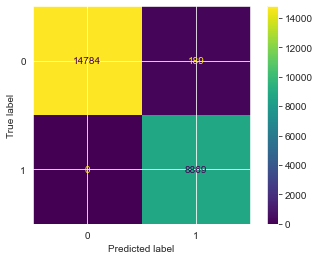

In [114]:
clf = GaussianNB()
clf.fit(X_train, Y_train)
GaussianNB()
plot_confusion_matrix(clf, X_test, Y_test)  
plt.show()